<a href="https://colab.research.google.com/github/AamirKhaan/Student-Academic-Performance/blob/master/01_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Path Setups

In [1]:
import os
import glob
import cv2 
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.utils import get_file
from PIL import Image

from IPython.display import clear_output
%matplotlib inline

In [2]:
CUSTOM_MODEL_NAME = 'alpr_ssd_mobnet' 
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [33]:
paths = {
    'WORKSPACE_PATH': os.path.join('codes', 'workspace'),
    'SCRIPTS_PATH': os.path.join('codes','scripts'),
    'APIMODEL_PATH': os.path.join('codes','models'),
    'ANNOTATION_PATH': os.path.join('codes', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('codes', 'workspace','images'),
    'MODEL_PATH': os.path.join('codes', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('codes', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('codes', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('codes', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('codes', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('codes', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('codes','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('codes', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# 2. Load Model 

In [5]:
import tensorflow as tf
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [6]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 3. Detect from an Image

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [8]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '*.jpg')

In [9]:
images_path= list(glob.glob(IMAGE_PATH))

In [10]:
print(f'There are {len(images_path):,} images in the dataset')

There are 64 images in the dataset


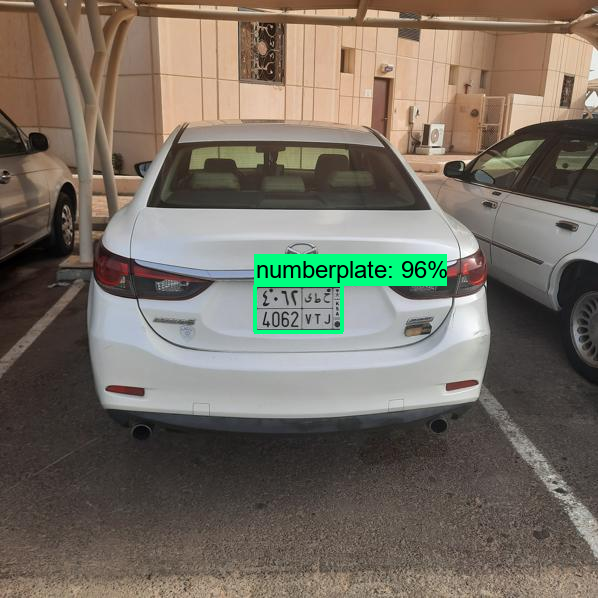

KeyboardInterrupt: 

In [11]:
for image in images_path:

    img = cv2.imread(image)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.2,
                agnostic_mode=False)
    
    img = Image.fromarray(image_np_with_detections[...,::-1])
    display(img)
    time.sleep(5)
    
    
    
    clear_output(wait=False)

In [36]:
image_number = 0

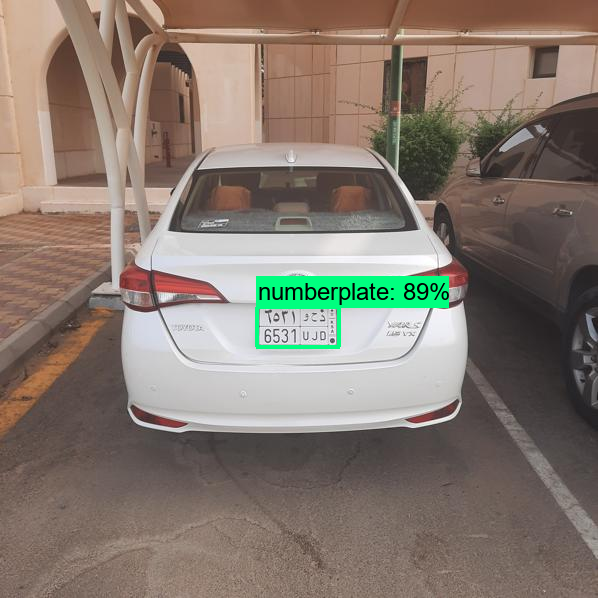

In [37]:
img = cv2.imread(images_path[image_number])
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1,
            min_score_thresh=.2,
            agnostic_mode=False)

img = Image.fromarray(image_np_with_detections[...,::-1])
display(img)

In [39]:
detection_threshold = 0.2
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [40]:
width = image.shape[1]
height = image.shape[0]

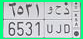

In [41]:
for idx, box in enumerate(boxes):
    roi = box*[height, width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    plate = Image.fromarray(region[...,::-1])
    display(plate)
plate.save(paths['IMAGE_PATH']+'\plates\P_'+str(image_number)+'.jpg')